In [1]:
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
#os.environ["CUDA_VISIBLE_DEVICES"]='0,1,2,3'
import sys
import argparse
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms
import videotransforms_attention

import numpy as np

from pytorch_i3d_attention_gaze import InceptionI3d

from z_my_egtea_dataset_attention_gaze import Egtea as Dataset

from pytorch_ranger import Ranger, RangerVA

Random Seed:  922


In [2]:
n_wkers = 8
b_sz = 24
mx_steps = 64e3

# try to set random seed
manualSeed = 922
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  922


In [3]:
def calculate_loss(i3d, dataloader):
    tot_loss = 0.0
    tot_gaze_loss = 0.0
    tot_loss = np.array([])
    tot_gaze_loss = np.array([])
    i3d.eval()
    
    with torch.no_grad():

        for data in dataloader:
            inputs, labels, gt_labels, gaze_locs = data

            # wrap them in Variable
            inputs = Variable(inputs.cuda())
            t = inputs.size(2)
            labels = Variable(labels.cuda())

            gt_labels = Variable(gt_labels.cuda())

            per_frame_logits, a_map = i3d(inputs)

            #print inputs.shape, per_frame_logits.shape, gaze_locs.shape #(12, 3, 16, 224, 224) (12, 106, 1) (12, 16, 2)

            # upsample to input size
            per_frame_logits = F.upsample(per_frame_logits, t, mode='linear')

            loss = F.cross_entropy(torch.max(per_frame_logits, dim=2)[0], gt_labels)
            #loss /= num_steps_per_update

            #tot_loss += loss.data.item() #/ len(inputs)
            tot_loss = np.append(tot_loss, loss.data.item())


            a_map = a_map.squeeze(1)

            map_N, map_t, map_height, map_width = a_map.shape
            map_Data_s = torch.zeros([map_N, map_t, map_height, map_width], dtype=torch.float32)

            for n_idx in range(map_N):
                gaze_avg1 = torch.mean(gaze_locs[n_idx, 0:8, :], dim=0)
                gaze_avg2 = torch.mean(gaze_locs[n_idx, 8:16, :], dim=0)

                x, y = gaze_avg1[0] * map_width, gaze_avg1[1] * map_height
                u, v = gaze_avg2[0] * map_width, gaze_avg2[1] * map_height
                sigma = 3
                for i in range(0, map_height):
                    for j in range(0, map_width):
                        map_Data_s[n_idx, 0, i, j] = torch.exp(-1.0 * ((j - x) * (j - x) + (i - y) * (i - y)) / (2 * sigma * sigma))
                        map_Data_s[n_idx, 1, i, j] = torch.exp(-1.0 * ((j - u) * (j - u) + (i - v) * (i - v)) / (2 * sigma * sigma))

            map_Data_s = map_Data_s.cuda()

            gaze_loss = F.mse_loss(map_Data_s, a_map)
            #gaze_loss /= num_steps_per_update

    #         tot_gaze_loss += gaze_loss.item() #/ len(inputs)
            tot_gaze_loss = np.append(tot_gaze_loss, gaze_loss.data.item())

        #return tot_loss/len(dataloader.dataset), tot_gaze_loss/len(dataloader.dataset)
    #    return tot_loss, tot_gaze_loss
        return tot_loss.mean(), tot_gaze_loss.mean()

In [4]:
#len dataset: 7800

In [5]:
def run(init_lr=0.1, max_steps=64e3, mode='rgb', batch_size=b_sz, save_model='./tmp/'):

    if mode == 'flow':
        root = './dataset/EGTEA_Gaze_plus/z_frames_flow'
    else:
        root = './dataset/EGTEA_Gaze_plus/z_frames_rgb'

    gaze_root = './dataset/EGTEA_Gaze_plus/z_gaze_data'
    train_split = './dataset/EGTEA_Gaze_plus/action_annotation/train_split4.txt'
    val_split = './dataset/EGTEA_Gaze_plus/action_annotation/val_split.txt'

    # setup dataset
    train_transforms = transforms.Compose([videotransforms_attention.RandomCrop(224),
                                           videotransforms_attention.RandomHorizontalFlip(),
    ])

    dataset = Dataset(train_split, 'training', root, gaze_root, mode, train_transforms)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_wkers, pin_memory=True)

    dataset_val = Dataset(val_split, 'val', root, gaze_root, mode, train_transforms)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=20, shuffle=True, num_workers=n_wkers, pin_memory=True)

    dataloaders = {'train': dataloader, 'val': dataloader_val}
    
    # setup the model
    if mode == 'flow':
        i3d = InceptionI3d(106, in_channels=2, expanded=False)
        i3d.load_state_dict(torch.load('models/flow_o.pt'), strict=False)
    else:
        i3d = InceptionI3d(106, in_channels=3, expanded=False)
        i3d.load_state_dict(torch.load('models/rgb_o.pt'), strict=False)
    
    #i3d.copy_attention_weights()

    i3d.cuda()
    i3d = nn.DataParallel(i3d, device_ids=[0, 1])

    lr = init_lr
    #optimizer = optim.SGD(i3d.parameters(), lr=lr, momentum=0.9, weight_decay=0.0000001)
    #lr_sched = optim.lr_scheduler.MultiStepLR(optimizer, [300, 1000])
    optimizer = Ranger(i3d.parameters())
    lr_sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
    
    scaler = torch.cuda.amp.GradScaler()

    num_steps_per_update = 8 # accum gradient
    steps = 0
    best_loss_val = 2.0
    best_steps = 0
    
    # train it
    while steps < max_steps:#for epoch in range(num_epochs):
        print(optimizer.param_groups[0]['lr'])
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                i3d.train(True)
            else:
                i3d.train(False)  # Set model to evaluate mode
                
            tot_loss = 0.0
            tot_gaze_loss = 0.0

            num_iter = 0
            optimizer.zero_grad()
            
            # Iterate over data.
            for data in dataloaders[phase]:
                num_iter += 1
                # get the inputs
                inputs, labels, gt_labels, gaze_locs = data
                

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                t = inputs.size(2)
                labels = Variable(labels.cuda())
                gt_labels = Variable(gt_labels.cuda())
                                    
                with torch.cuda.amp.autocast():
                    per_frame_logits, a_map = i3d(inputs)

                    # upsample to input size
                    per_frame_logits = F.upsample(per_frame_logits, t, mode='linear')

                    loss = F.cross_entropy(torch.max(per_frame_logits, dim=2)[0], gt_labels)
                    #loss = SoftTargetCrossEntropy()(torch.max(per_frame_logits, dim=2)[0], gt_labels)
                    
                    loss /= num_steps_per_update

                    tot_loss += loss.data.item()
                    
                    a_map = a_map.squeeze(1)

                    map_N, map_t, map_height, map_width = a_map.shape
                    map_Data_s = torch.zeros([map_N, map_t, map_height, map_width], dtype=torch.float32)

                    for n_idx in range(map_N):
                        gaze_avg1 = torch.mean(gaze_locs[n_idx, 0:8, :], dim=0)
                        gaze_avg2 = torch.mean(gaze_locs[n_idx, 8:16, :], dim=0)

                        x, y = gaze_avg1[0] * map_width, gaze_avg1[1] * map_height
                        u, v = gaze_avg2[0] * map_width, gaze_avg2[1] * map_height
                        sigma = 3
                        for i in range(0, map_height):
                            for j in range(0, map_width):
                                map_Data_s[n_idx, 0, i, j] = torch.exp(-1.0 * ((j - x) * (j - x) + (i - y) * (i - y)) / (2 * sigma * sigma))
                                map_Data_s[n_idx, 1, i, j] = torch.exp(-1.0 * ((j - u) * (j - u) + (i - v) * (i - v)) / (2 * sigma * sigma))

                    map_Data_s = map_Data_s.cuda()

                    gaze_loss = F.mse_loss(map_Data_s, a_map)
                    gaze_loss /= num_steps_per_update

                    tot_gaze_loss += gaze_loss.item()

                    loss_two = loss + gaze_loss*0.1
                
                scaler.scale(loss_two).backward()
                #loss_two.backward()

                if num_iter == num_steps_per_update and phase == 'train':
                    steps += 1
                    num_iter = 0
                    #optimizer.step()
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    #lr_sched.step()
                    lr_sched.step(loss_two)
                    
                    num_steps_to_eval = 10
                    
                    if steps % num_steps_to_eval == 0:                           
                        with torch.cuda.amp.autocast():
                            loss_val, gaze_loss_val = calculate_loss(i3d, dataloader_val)
                            
                            print('Step {}/{}'.format(steps, max_steps))
                            print('Train Tot Loss: {:.4f} Train Gaze Loss: {:.4f} - Val Tot Loss: {:.4f} Val Gaze Loss: {:.4f}'.format(tot_loss/num_steps_to_eval, tot_gaze_loss/num_steps_to_eval, loss_val, gaze_loss_val))
                            
                            with open('output.txt', 'a') as f:
                                f.write('Step {}/{}\n'.format(steps, max_steps))
                                f.write('Train Tot Loss: {:.4f} Train Gaze Loss: {:.4f} - Val Tot Loss: {:.4f} Val Gaze Loss: {:.4f}\n'.format(tot_loss/num_steps_to_eval, tot_gaze_loss/num_steps_to_eval, loss_val, gaze_loss_val))                            
                        
                            if loss_val < best_loss_val:
                                if os.path.exists(save_model+str(best_steps).zfill(6)+'_best.pt'):
                                    os.remove(save_model+str(best_steps).zfill(6)+'_best.pt')
                                
                                best_loss_val = loss_val
                                best_steps = steps
                                
                                torch.save(i3d.module.state_dict(), save_model+str(steps).zfill(6)+'_best.pt')
                        
                        if steps % 150 == 0:
                            # save model
                            torch.save(i3d.module.state_dict(), save_model+str(steps).zfill(6)+'.pt')
                        tot_loss = tot_gaze_loss = 0.

In [ ]:
run(max_steps=600)

0.001
----------


/data/axel/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/data/axel/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/data/axel/miniconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internall

Step 10/600
Train Tot Loss: 2.0267 Train Gaze Loss: 0.3264 - Val Tot Loss: 2.1795 Val Gaze Loss: 0.1852


In [5]:
i3d = InceptionI3d(106, in_channels=2, expanded=False)

In [7]:
i3d.end_points['Conv3d_1a_7x7']._activation_fn

In [38]:
import re

path = './results/'

steps = []
train_loss = []
train_gaze_loss = []
val_loss = []
val_gaze_loss = []

with open(path + 'expandido_mp_ranger.txt', 'r') as f:
    lines = f.readlines()
    
    for line in lines:
    
        if line.startswith('Step'):
            steps.append(int(line.split('/')[0].split(' ')[1]))
        else:
            train = line.split('-')[0]
            val = line.split('-')[1]
            
            train_loss.append(float(re.findall("\d+\.\d+", train)[0]))
            train_gaze_loss.append(float(re.findall("\d+\.\d+", train)[1]))
            val_loss.append(float(re.findall("\d+\.\d+", val)[0]))
            val_gaze_loss.append(float(re.findall("\d+\.\d+", val)[1]))

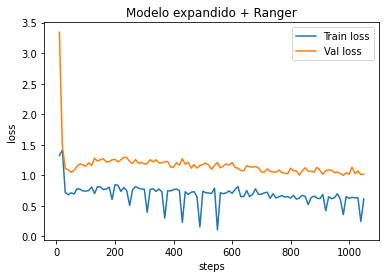

In [39]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'steps': steps,
                   'Train loss': train_loss,
                   'Val loss': val_loss,
                   #'Train gaze loss': train_gaze_loss,
                   #'Val gaze loss': val_gaze_loss
                   })

df = df.melt('steps', var_name='',  value_name='loss')
g = sns.lineplot(x="steps", y="loss", hue='', data=df).set_title('Modelo expandido + Ranger')

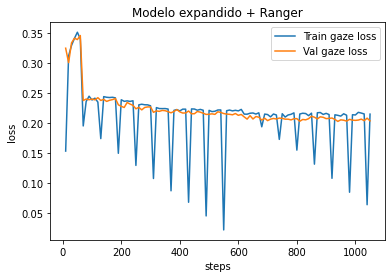

In [40]:
df = pd.DataFrame({'steps': steps,
                   #'Train loss': train_loss,
                   #'Val loss': val_loss,
                   'Train gaze loss': train_gaze_loss,
                   'Val gaze loss': val_gaze_loss
                   })

df = df.melt('steps', var_name='',  value_name='loss')
g = sns.lineplot(x="steps", y="loss", hue='', data=df).set_title('Modelo expandido + Ranger')